# Download, read and plot SMAP data with xarray and rioxarray

## Overview

### Introduction

This notebook demonstrates searching for, downloading, reading and plotting SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture data using `earthaccess`, `xarray` and `cartopy`.  `earthaccess` makes searching for and downloading NASA Earth science data easy.  `xarray` is a commonly used, high-level package for working with n-dimensional gridded data.  It makes reading HDF5 data easy and simplifies common Earth and atmospheric science workflows.  `cartopy` provides a simple plotting interface to display geospatial data and create maps complete with coastlines, country and state boundaries, and other topographic features.  Finally, we demonstrate how to transform and resample the data using `rioxarray`, an add-on for `xarray` that brings many of the geospatial functions from `rasterio` to n-dimensional data.

To use `xarray` and `rioxarray`, we need information about the coordinate reference system (CRS), also known as the spatial reference system (SRS), and the coordinate system of the grid.  Many datasets that conform to CF-Conventions already contain this information within the file so that `rioxarray` can read it.  Unfortunately, the SMAP data files do not contain this information.  The tutorial shows how to add this information and add additional information that makes working with N-dimensional data much easier.

These issues are common to many datasets.  These sections of the tutorial can be thought of as a guide to working with and "fixing" datasets with missing or inadequate metadata.  You can also think of it as a guide to producing CF-compliant data.

The tutorials use the SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 8 (SPL3SMP, DOI:10.5067/OMHVSRGFX38O).

[Data set landing page](https://nsidc.org/data/spl3smp/versions/8)  
[User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf)


### Learning Goals

By the end of this tutorial you will know how to:
1. search for and access SMAP data using `earthaccess`;
2. open the SMAP data with `xarray`;
3. add CRS and coordinate system information;
4. add dataset metadata;
5. plot the data on a map;
6. transform and resample the data to a new CRS.


### Prerequisites
1. You will need an Earthdata login to download the data.
2. You will need to have created and activated the `smap-tutorials` environment.

## Tutorial

### Import libraries

In [1]:
from pathlib import Path  # for working with paths on the local file system
from pprint import pprint  # for nice printing

# For data search and download
import earthaccess

# For reading and working with the data
# import rioxarray
import xarray as xr
import rioxarray
import numpy as np

# For defining CRS and image coordinate system
from affine import Affine
from pyproj import CRS

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/apbarret/mambaforge/envs/nsidc-tutorials-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Search for SMAP data

We will use `earthaccess` to search for SMAP Level 3 files for March 2017.  The first step is to authenticate using `earthaccess.login`.  We can then use `search_data` to search for data.

In [2]:
auth = earthaccess.login()

In [3]:
results = earthaccess.search_data(
    short_name = 'SPL3SMP',
    version = '009',
    cloud_hosted = True,
    temporal = ('2017-03-01','2017-03-31')
)

## Download files

If you haven't already, we'll download the files to a local directory called `smap_data`.  We do this by setting  `local_path="smap_data"`.  You can chhose a different local path if you want.  If the directory passed to `local_path` does not exist, `earthaccess` will create it for you.

`earthaccess.download` checks if the files already exist in the local download directory.  If they do, they will not be downloaded.

In [4]:
smap_files = earthaccess.download(results, local_path="smap_data")

QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 5377.76it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:51<00:00,  1.65s/it]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 228512.17it/s]


The paths to the downloaded files are written to `smap_files`.

In [5]:
smap_files

[PosixPath('smap_data/SMAP_L3_SM_P_20170301_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170302_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170303_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170304_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170305_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170306_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170307_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170308_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170309_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170310_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170311_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170312_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170313_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170314_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170315_R19240_001.h5'),
 PosixPath('smap_data/SMAP_L3_SM_P_20170316_R19240_001.h5'),
 PosixPath('smap_data/SM

#### Read the data

HDF5 files are organized into _groups_.  These groups can contain  sub-_groups_ or _datasets_.  This is similar to the directory structure on your local filesystem that is organized into directories, sub-directories and files.  The top group is called the _root_ group.  The SMAP L3 files contain three groups.

```
root  
  |- Metadata  
  |- Soil_Moisture_Retrieval_Data_AM  
  |- Soil_Moisture_Retrieval_Data_PM  
```

<div class="alert alert-block alert-info">
<b>Note:</b> You can find out how an HDF5 file is structured, what groups exist, and what variables the file contains using tools like `h5dump`, online HDF5 viewers like [MyHDF5](https://myhdf5.hdfgroup.org/help), or lower level python tools like h5py.
</div>

`xarray.open_dataset` can only read one HDF Group at a time from an HDF5 file.  If you want to read the entire HDF file you can use `xarray.open_datatree`.  See [work_with_smap_data_using_datatree]().

In the following example, we read the `Soil_Moisture_Retrieval_Data_AM` group.  This is done by passing the group name using the `group` keyword.  If you wanted data for a subgroup or a dataset one or more levels down, the argument passed to `group` would look like a filepath; for example `"group/subgroup/dataset"`.

We add the `phoney_dims='sort'` keyword argument to allow `xarray` to assign dimensions.

The `decode_timedelta=True` is also set to supress a warning from `xarray`.

In [6]:
gds = xr.open_dataset(smap_files[0], group='Soil_Moisture_Retrieval_Data_AM', 
                      phony_dims='sort', engine="h5netcdf", decode_coords="all",
                      decode_timedelta=True)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (phony_dim_0: 406, phony_dim_1: 964,
                                  phony_dim_2: 3)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/53)
    EASE_column_index            (phony_dim_0, phony_dim_1) float32 2MB ...
    EASE_row_index               (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo                       (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_dca                   (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_scah                  (phony_dim_0, phony_dim_1) float32 2MB ...
    albedo_scav                  (phony_dim_0, phony_dim_1) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity           (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_dca       (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_scah      (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_opacity_scav      (phony_dim_0, phony_dim_1) float32 2MB ...
    vegetation_water_content     (phony_dim_0, phony_dim_1) float32 2MB ...

The `Soil_Moisture_Retrieval_Data_AM` group contains 53 data variables.  Click on the arrow beside **Data variables** to see them.  However, we can already see some issues with the dataset that need to be addressed to allow you to take full advantage of `xarray` and other tools.  There are no _coordinate variables_ or _indexes_, so we cannot use `xarray` to do any geopatial analysis with the data, such as plotting the data on a map, subsetting the data to a geographic region, or transforming the data to another coordinate system.  

Another issue is that the _dimensions_, `phony_dim_0`, `phony_dim_1`, and `phony_dim_2`, are not meaningful.  A user and a software tool needs to figure out which dimensions are spatial dimensions, as well as what the third dimension is.  This happens because no dimensions were assigned to datasets when the dataset was created.  `xarray` has to generate some "phony" variables.

```{note}
Actually the file does contain `latitude` and `longitude` arrays but `xarray` does not recognize these as coordinate variables.
```

In the following section, we fix these issues so that we can take full advantage of `xarray` to analyze the data.

## Create a georeferenced `xarray.Dataset`

In the previous section, we identified several issues with the dataset that prevent us from using `xarray` (or other tools) to work with the data efficiently.  What follows is a short version of how to fix these issues.  See [create_georeferenced_xarray_dataset]() for a more detailed explanation of what we are doing.

In the following sections we will:

1. add meaningful dimension names;
2. add coordinate information to the dataset;
3. add a coordinate reference system information the dataset.

#### Add meaningful dimension names

We want to change the dimensions from `phony_dim_0`, `phony_dim_1`, and `phony_dim_2` to something meaningful.  First, we need figure out what the dimensions are.

From the [User Guide](https://nsidc.org/sites/default/files/documents/user-guide/spl3smp-v009-userguide.pdf), we can see that the EASE-Grid 2.0 Global 36 km grid is 964 columns by 406 rows.  `phony_dim_0` matches the number of rows in the grid, so we'll assume that `phony_dim_0` is the y-axis.  Similarly, `phony_dim_1` matches the number of columns, so we'll assume `phony_dim_1` is the x-axis.  The `land_cover_class` and `land_cover_class_fraction` data variables are the only variables with a third dimension.  The `long_name` attribute for these variables indicates that the third dimension is and index for IGBP land cover type:

> An enumerated type that specifies the most common landcover class in the grid cell based on the IGBP landcover map. The array order is longitude (ascending), followed by latitude (descending), and followed by IGBP land cover type descending dominance (only the first three types are listed)

So we'll rename the coordinates:

 - `phony_dim_0 --> y`
 - `phony_dim_1 --> x`
 - `phony_dim_2 --> igbp_class`

We can do this using `rename_dims`, which takes a dictionary as an argument, where keys are the old dimension name and values are the new dimension name.

In [7]:
gds = gds.rename_dims({'phony_dim_0': 'y', 'phony_dim_1': 'x', 'phony_dim_2': 'igbp_class'})
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Dimensions without coordinates: y, x, igbp_class
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

We can see that the dimension names are now `y`, `x` and `igbp_class`.  When we look at the data variables, we can see that the dimensions for these variables have also been renamed. 

#### Adding coordinates

Now that we have renamed the dimensions, the next step is to assign coordinates.  Even though the SMAP data contain `latitude` and `longitude` variables, `xarray` does not recognize these variables as _coordinate variables_.  In addition to this, the `latitude` and `longitude` variables are 2-dimensional grids and have missing values.  Both of these characteristics make selecting and subsetting data difficult.  Especially because the SMAP data are on a projected grid.  Using 1-dimensional coordinates for the `x` and `y` dimensions makes these kinds of searches more efficient.

The SMAP data is in the EASE-Grid 2.0 Global 36 km grid.  This is a projected coordinate system.  Below we calculate these `x` and `y` coordinates and assign them.

We need two bits of information; the grid parameters so we can calculate the `x` and `y` coordinates of grid cell centers; and the Coordinate Reference System (CRS), which relates these coordinates to points on Earth.  This information is not available in the files so we need to do some data sleuthing.  

The CRS is defined in Table 4 of the [User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf).  Fortunately, we can use the EPSG code, which is 6933, as _shorthand_ for the CRS.

To define the grid, we need to know the width and height of the grid cells in meters, and the `x` and `y` coordinates of the upper-left-corner of the upper-left grid cell.  We already know that the grid is 964 columns by 406 rows.  Table 5 of the [User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf) contains part of the grid definition but it is not complete.  Although, all the information we need to define the grid is in [NSIDC's Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-36-km-resolution-ease-grids), the values given in the tables are not precise enough.

Exact definitions of CRS, projection and grid parameters can be found in the Grid Parameter Definition (gpd) files in the [`mapxmaps` GitHub repository](https://github.com/nsidc/mapxmaps).  These gpd files have a somewhat esoteric format, so might take a little bit to understand.  It is important that the grid definition is exact because we cannot merge datasets if the coordinates do not match, even to the 9th decimal place.  We have calculated the exact values required here.  See [create_geospatial_xarray_datasets]() for how to calculate these parameters.

In [8]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

We can use an [_affine transformation_](https://affine.readthedocs.io/en/latest/index.html) to calculate the `x` and `y` coordinates for the dataset.  The _affine transformation_ maps the row and column indices (i.e. the image coordinates) to projected coordinates.  See [create_geospatial_xarray_datasets]() for more details on Affine transformations.

We use the [`affine`](https://affine.readthedocs.io/en/latest/index.html) Python package for this.

In [9]:
transform = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)
transform

Affine(36032.220840584, 0.0, -17367530.4451615,
       0.0, -36032.220840584, 7314540.8306386)

The Affine matrix `transform` is then used to transform column and row indices into `x` and `y` coordinates.

First, we define 1-dimensional vectors of the column and row indices for center points of grid cells.  The grid origin (the upper-left corner of the upper-left groid cell) is $(0,0)$, so center points are offset by 0.5 of a grid cell.

In [10]:
nrows, ncolumns, nclass = gds.sizes['y'], gds.sizes['x'], gds.sizes['igbp_class']
row = np.arange(0.5, nrows)
column = np.arange(0.5, ncolumns)

Now we calculate `x` and `y` coordinates.  The `_` is a Pythonic way to create a _Throwaway variable_.

In [11]:
x, _ = transform * (column, 0.5)
_, y = transform * (0.5, row)
igbp_class = np.arange(nclass)

Before we assign coordinates to the `Dataset`, we should add some attributes to the _coordinate variables_.

In [12]:
x_da = xr.DataArray(
    x, 
    dims=['x'], 
    attrs={
        "units": "m",
        "long_name": "x coordinate of projection",
        "standard_name": "projection_x_coordinate",
    }
)

y_da = xr.DataArray(
    y, 
    dims=['y'], 
    attrs={
        "units": "m",
        "long_name": "y coordinate of projection",
        "standard_name": "projection_y_coordinate",
    }
)

igbp_da = xr.DataArray(
    igbp_class,
    dims=['igbp_class'],
    attrs={
        "long_name": "index for IGBP land cover type",
    }
)

We use `assign_coords` to create coordinate variables.

In [13]:
gds = gds.assign_coords(x=x_da, y=y_da, igbp_class=igbp_da)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                            (y) float64 3kB 7.297e+06 ... -7.297e+06
  * igbp_class                   (igbp_class) int64 24B 0 1 2
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

This information should be sufficient for plotting and most other operations.  However, if we want to reproject the data we should define the CRS and spatial coordinates, and transform.  We do this using `rioxarray` accessors.

In [14]:
gds.rio.write_crs(6933, grid_mapping_name='wgs84_easegrid2_global', inplace=True)
gds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
gds.rio.write_coordinate_system(inplace=True)
gds.rio.write_transform(transform)
gds.rio.write_grid_mapping('wgs84_easegrid2_global', inplace=True)
gds

<xarray.Dataset> Size: 99MB
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                            (y) float64 3kB 7.297e+06 ... -7.297e+06
  * igbp_class                   (igbp_class) int64 24B 0 1 2
    wgs84_easegrid2_global       int64 8B 0
Data variables: (12/53)
    EASE_column_index            (y, x) float32 2MB ...
    EASE_row_index               (y, x) float32 2MB ...
    albedo                       (y, x) float32 2MB ...
    albedo_dca                   (y, x) float32 2MB ...
    albedo_scah                  (y, x) float32 2MB ...
    albedo_scav                  (y, x) float32 2MB ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 2MB ...
    vegetation_opacity           (y, x) float32 2MB ...
    vegetation_opacity_dca       (y, x) float32 2MB ...
    vegetation_opacity_scah      (y, x) float32 2MB ...
    vegetation_opacity_scav      (y, x) float32 2MB ...
    vegetation_water_content     (y, x) float32 2MB ...

A new special _coordinate variable_ has been created with the official name of the EASE-Grid 2.0 Global CRS.  Information about the CRS and grid definition can be found using `rasterio` accessors. 

In [15]:
print(gds.latitude.rio.grid_mapping)
print(gds.rio.bounds())

wgs84_easegrid2_global
(-17367530.4451615, -7314540.830638505, 17367530.445161473, 7314540.8306386)


## Plot the data

We can now plot the data on a map using cartopy.

We use `cartopy.crs.epsg` method to define a cartopy projection from the EPSG we just assigned to the dataset.

The map projection we use to display the data is passed to the `subplot_kws` keyword as a dictionary.  We also set the background of the plot to `lightgrey` using this dictionary.

We also need a colorbar to interpret the colors used in the plot.  We use the `cbar_kwargs` keyword to scale the size of the colorbar using `shrink` and set the units of the colorbar using `label`.  In this case, we get the correct units from the units attribute of the data variable. 

Text(0.5, 1.0, 'SMAP Soil Mosture')

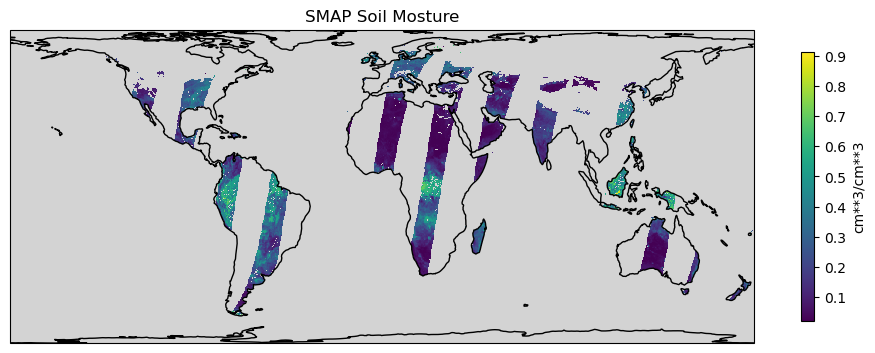

In [16]:
EASEGrid2 = ccrs.epsg(gds.rio.crs.to_epsg())

p = gds.soil_moisture.plot(
    subplot_kws=dict(
        projection=EASEGrid2, 
        facecolor="lightgrey",
    ),
    cbar_kwargs=dict(
        shrink=0.5,
        label=gds.soil_moisture.attrs["units"],
    ),
    figsize=(12,7),
)

p.axes.coastlines()
p.axes.set_title("SMAP Soil Mosture")